In [1]:
# this enable automatic reloading of libraries
%load_ext autoreload
%autoreload 2

%matplotlib notebook
from clib.bellhop import *
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
from matplotlib.animation import FuncAnimation

In [2]:
s = bellhop({'gs': {'data_files': '/home/datawork-lops-osi/mlecorre/POLGYR/HIS/*his*.nc', \
                      'hgrid_file': '/home/datawork-lops-osi/jgula/POLGYR/polgyr_grd.nc',
                 'vgrid_file': '/home/datawork-lops-osi/mlecorre/POLGYR/HIS/polgyr_his.03960.nc',\
                     'lon': -20.5, 'lat': 48., 'plot_map': False, \
                     'contour':False}},  zmax = 4900)

-- Grid object
dim lon_rho: 1602  2002
lon_rho min= -72.241, max=11.166
lat_rho min= 35.893, max=69.856
h min= 20.000, max=6094.148
Uses the following output file: /home/datawork-lops-osi/mlecorre/POLGYR/HIS/polgyr_his.00000.nc
Uses the following time : 0


---
---

In [3]:
# R0 : Gulf Stream - profils tous les 50 et 10km
# R1 : Gulf Stream - profil tous les 5km
# R2 : Atlantique - profils tous les 50, 10 et 5km - raté (pas de time)
# R3 : Atlantique - test 
# R4 : Atlantique - profils tous les 50, 10 et 5km

---
---
# Initialisation of parameters

In [4]:
dire = '/home1/datawork/mponchar/cognac/R4/'
Arr, Pos = s.read_arrivals_asc(dire+'OUT00/0_time0.arr', Narrmx = 76)

Max.number of arrivals for source index 0 is 75


In [5]:
Nsd = np.shape(Pos['s']['depth'])[0]
Nrd = np.shape(Pos['r']['depth'])[0]
Nrr = np.shape(Pos['r']['range'])[0]
print('Number of source depths   : Nsd = ', Nsd)
print('Number of receiver depths : Nrd = ', Nrd)
print('Number of receiver ranges : Nrr = ', Nrr)

Number of source depths   : Nsd =  1
Number of receiver depths : Nrd =  51
Number of receiver ranges : Nrr =  101


In [6]:
### sonar equation
SL = 185                 # Souce level (dB)
NL = 81.7                # Noise level (dB)
DI = 0                   # Directivity index (dB)
B = 200                  # bandwidth (Hz)
T = 1                    # transmitted signal duration (s)
PG = 10.0*np.log10(B*T)  # Processing gain (dB)

#RT  = SL - TL - NL + DI + PG 
seuil_d = 10.

In [7]:
# Create time table from bellhop output data. Based on detection treshold method.
def time_table (Arr) :
    T = np.zeros( (Nrr, Nrd, Nsd) )
    for isd1 in range (Nsd):
        for ird1 in range (Nrd) : 
            for irr1 in range (Nrr) :
                Narr = int(Arr['Narr'][irr1, ird1, isd1])
                if not Narr ==0 :
                    A = abs(Arr['A'][irr1, :Narr, ird1, isd1])  # amplitude 
                    TL = - 20.0*np.log10(A)
                    RL = SL - TL - NL +DI + PG    # received level 
                    t = Arr['delay'][irr1, :Narr, ird1, isd1]
                    t_ok = t[np.where(RL > seuil_d)]

                    if len(t_ok > 0): 
                        t_min = np.min(t_ok)
                        T[irr1,ird1,isd1] = t_min  
                    else : 
                        T[irr1,ird1,isd1] = np.NaN
                else : 
                    T[irr1,ird1,isd1] = np.NaN
    return (T)

In [8]:
isd = 0    # source number (only 1 source here)
R = np.array(Pos['r']['range'])
Z = np.array(Pos['r']['depth'])

---
---
# Creation of matrix of results

In [ ]:
### Tous les infos dans les noms de fichiers
nb_files = 7
nb_times = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
nb_dist = [np.NaN, 50, 10, 5]

### Matrices contenant toutes les cartes d'erreurs (pour profils tous les 50 et 10 km)
MAT_50 = np.zeros((Z.size, R.size, nb_files*len(nb_times)))
MAT_10 = np.zeros((Z.size, R.size, nb_files*len(nb_times)))
MAT_5  = np.zeros((Z.size, R.size, nb_files*len(nb_times)))

L_name = []
time = []
n = -1

for i in range (nb_files):
    if len(str(i))==1 : 
        folder = 'OUT0'+str(i)
    else : 
        folder = 'OUT'+str(i)

    for j in range(len(nb_times)):
        n+=1
        print(n)
        time.append(12*n)
        file0 = str(i)+'_time'+str(nb_times[j])
        L_name.append(file0+'.arr')
        print(L_name[n])
        Tables = np.zeros ((Z.size, R.size, len(nb_dist)))
        for k in range (len(nb_dist)) :
            if np.isnan(nb_dist[k]) : 
                file1=''
            else : 
                file1 = '_%skm'%str(nb_dist[k])
            path = folder+'/'+file0+file1+'.arr'
            ###
            Arr, Pos = s.read_arrivals_asc(dire+path, Narrmx = 1000)
            T = time_table(Arr)
            Tables[:,:,k]=T[:,:,0].T
        
        diff_50 = Tables[:,:,1] - Tables[:,:,0]
        MAT_50[:,:,n] = diff_50
        diff_10 = Tables[:,:,2] - Tables[:,:,0]
        MAT_10[:,:,n] = diff_10
        diff_5  = Tables[:,:,3] - Tables[:,:,0]
        MAT_5[:,:,n] = diff_5

In [9]:
#np.save('MAT_50', MAT_50)
#np.save('MAT_10', MAT_10)
#np.save('MAT_5', MAT_5)
#np.save('time', time)
MAT_50 = np.load('results_ATL/MAT_50.npy')
MAT_10 = np.load('results_ATL/MAT_10.npy')
MAT_5  = np.load('results_ATL/MAT_5.npy')
time   = np.load('results_ATL/time.npy')

---
---
# Animations 

- https://github.com/markjay4k/fourier-transform/blob/master/Animated%20Sinc%20and%20FT%20example.ipynb
- https://brushingupscience.com/2016/06/21/matplotlib-animations-the-easy-way/

<IPython.core.display.Javascript object>


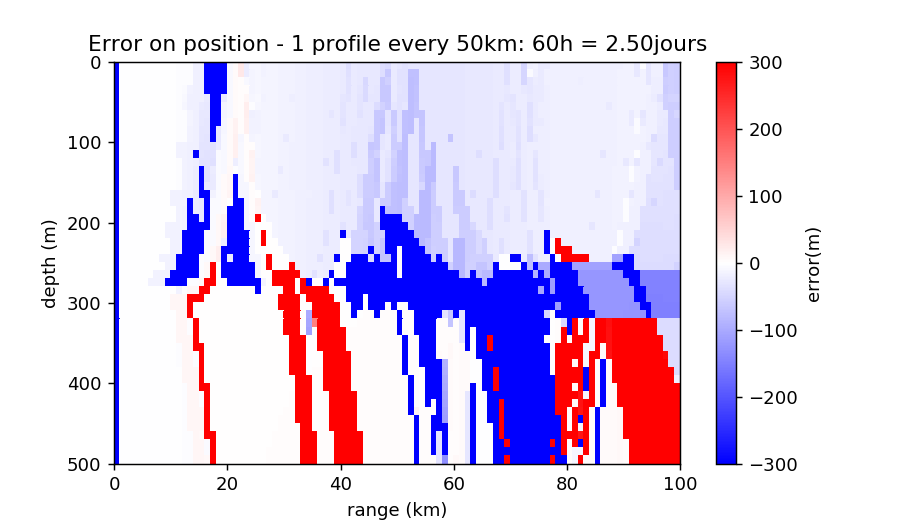

In [16]:
### Animation
fig, ax = plt.subplots(figsize=(7, 4))
ax.set(xlim=(0., 100.), ylim=(0., 500.))
   
cax = ax.pcolormesh(R/1000., Z, MAT_50[:, :, 0]*1500., vmin=-300., vmax=300.,cmap='bwr')
cbar = fig.colorbar(cax)
plt.gca().invert_yaxis()
plt.xlabel('range (km)')
plt.ylabel('depth (m)')
cbar.set_label("error(m)")
    
def animate(i):
    cax.set_array((MAT_50[:-1,:-1,i]*1500.).flatten())
    plt.title('Error on position - 1 profile every 50km: %dh = %.2fjours' %(time[i],\
                                                                        time[i]/24.))

anim = FuncAnimation(fig, animate, interval=5.e2, frames=MAT_50.shape[2])
plt.draw()
plt.show()

In [15]:
# export the animation
#anim.save('error_profile_50km.gif', writer='imagemagick')

<IPython.core.display.Javascript object>


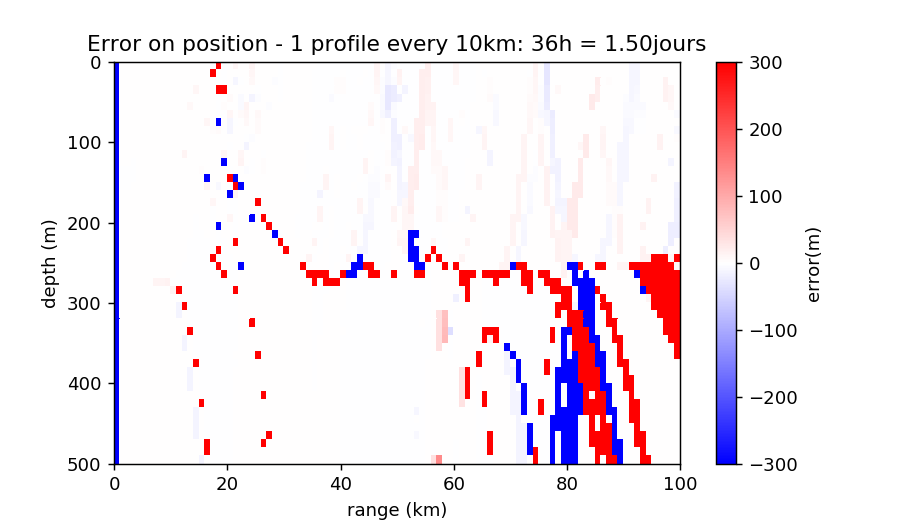

In [19]:
### Animation
fig, ax = plt.subplots(figsize=(7, 4))
ax.set(xlim=(0., 100.), ylim=(0., 500.))
   
cax = ax.pcolormesh(R/1000., Z, MAT_10[:, :, 0]*1500., vmin=-300., vmax=300.,cmap='bwr')
cbar = fig.colorbar(cax)
plt.gca().invert_yaxis()
plt.xlabel('range (km)')
plt.ylabel('depth (m)')
cbar.set_label("error(m)")
    
def animate(i):
    cax.set_array((MAT_10[:-1,:-1,i]*1500.).flatten())
    plt.title('Error on position - 1 profile every 10km: %dh = %.2fjours' %(time[i],\
                                                                        time[i]/24.))

anim = FuncAnimation(fig, animate, interval=5.e2, frames=MAT_10.shape[2])
plt.draw()
plt.show()

In [18]:
# export the animation
#anim.save('error_profile_10km.gif', writer='imagemagick')

<IPython.core.display.Javascript object>


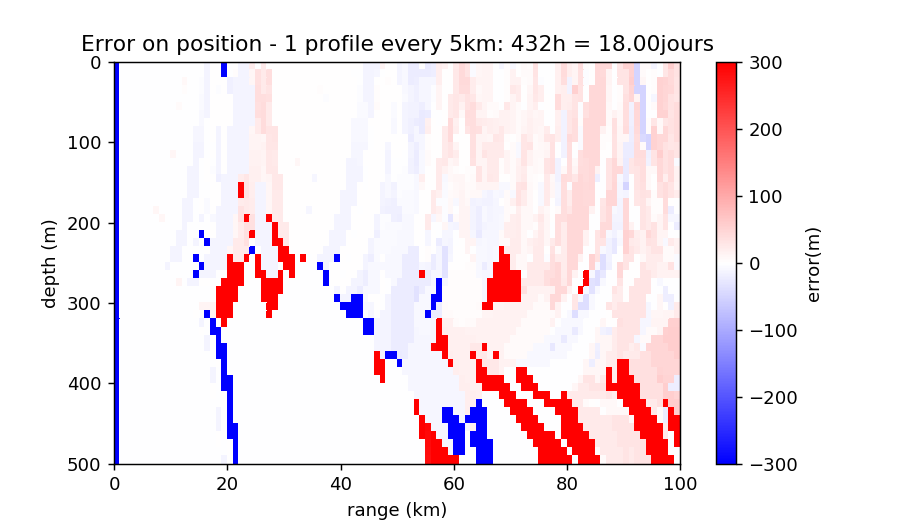

In [22]:
### Animation
fig, ax = plt.subplots(figsize=(7, 4))
ax.set(xlim=(0., 100.), ylim=(0., 500.))
   
cax = ax.pcolormesh(R/1000., Z, MAT_5[:, :, 0]*1500., vmin=-300., vmax=300.,cmap='bwr')
cbar = fig.colorbar(cax)
plt.gca().invert_yaxis()
plt.xlabel('range (km)')
plt.ylabel('depth (m)')
cbar.set_label("error(m)")
    
def animate(i):
    cax.set_array((MAT_5[:-1,:-1,i]*1500.).flatten())
    plt.title('Error on position - 1 profile every 5km: %dh = %.2fjours' %(time[i],\
                                                                        time[i]/24.))

anim = FuncAnimation(fig, animate, interval=5.e2, frames=MAT_5.shape[2])
plt.draw()
plt.show()

In [21]:
# export the animation
#anim.save('error_profile_5km.gif', writer='imagemagick')

---
---
# Mean error 

<IPython.core.display.Javascript object>


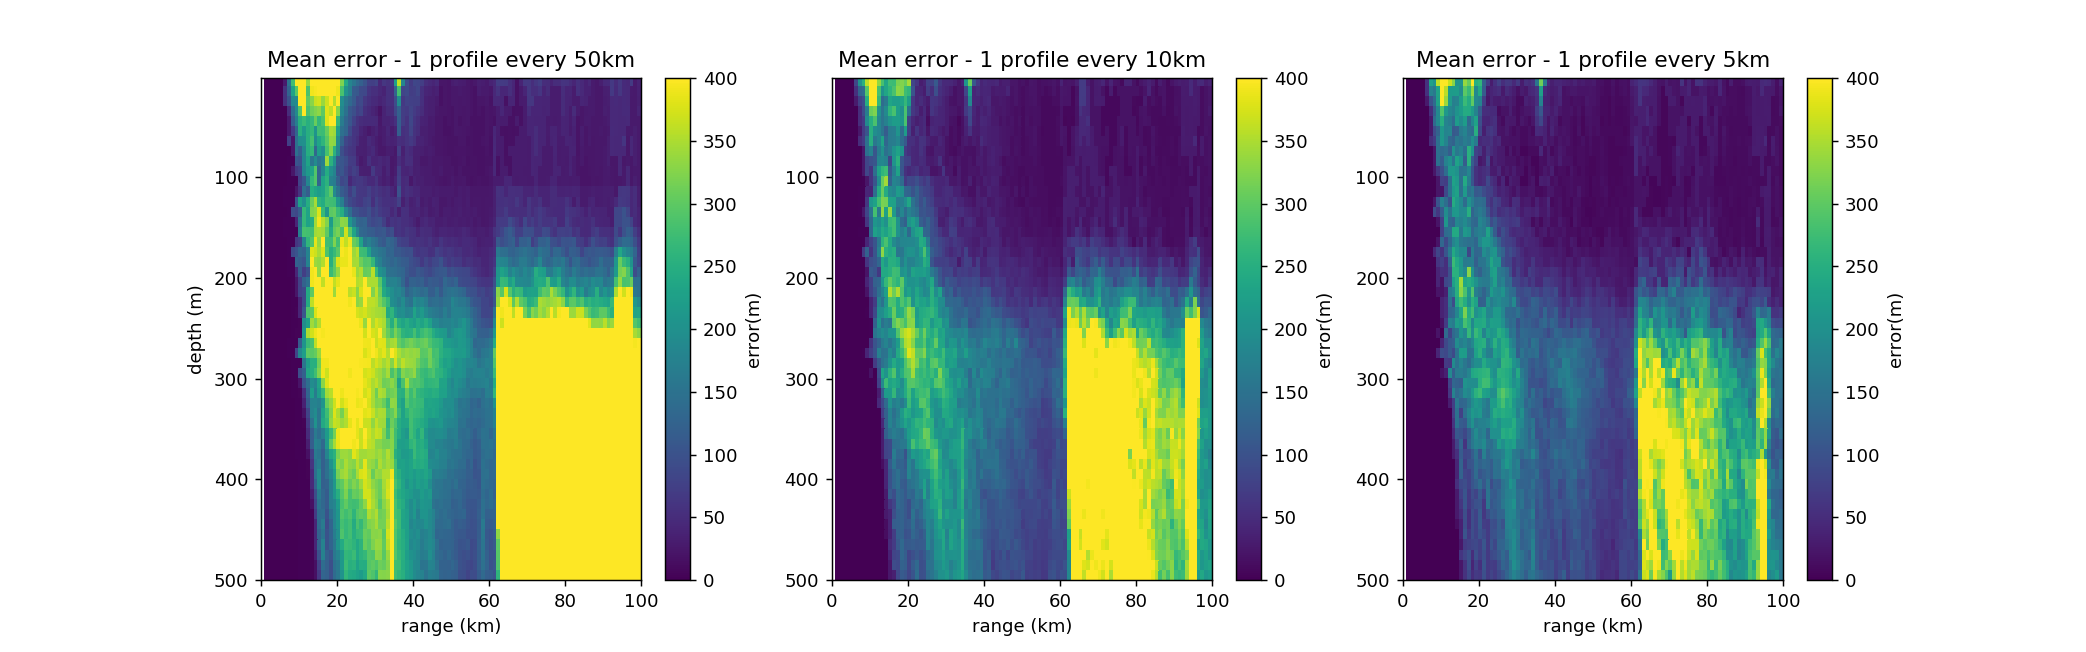

In [10]:
err_moy = np.zeros((Z.size, R.size))
for i in range (MAT_50.shape[2]):
    err_moy += abs(MAT_50[:,:,i]*1500.)
err_moy50 = err_moy/MAT_50.shape[2]

err_moy = np.zeros((Z.size, R.size))
for i in range (MAT_10.shape[2]):
    err_moy += abs(MAT_10[:,:,i]*1500.)
err_moy10 = err_moy/MAT_10.shape[2]

err_moy = np.zeros((Z.size, R.size))
for i in range (MAT_5.shape[2]):
    err_moy += abs(MAT_5[:,:,i]*1500.)
err_moy5 = err_moy/MAT_5.shape[2]


#plot
plt.figure(figsize=(16,5))
plt.subplot(131)
plt.pcolormesh(R/1000., Z, err_moy50, vmin=0., vmax=400.)
cbar = plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel('range (km)')
plt.ylabel('depth (m)')
plt.title('Mean error - 1 profile every 50km')
cbar.set_label("error(m)")

plt.subplot(132)
plt.pcolormesh(R/1000., Z, err_moy10, vmin=0., vmax=400.)
cbar = plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel('range (km)')
#plt.ylabel('depth (m)')
plt.title('Mean error - 1 profile every 10km')
cbar.set_label("error(m)")

plt.subplot(133)
plt.pcolormesh(R/1000., Z, err_moy5, vmin=0., vmax=400.)
cbar = plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel('range (km)')
#plt.ylabel('depth (m)')
plt.title('Mean error - 1 profile every 5km')
cbar.set_label("error(m)")

plt.savefig('mean_error_ATL', dpi=100)

In [24]:
# moyenne en chaque point (65valeurs), puis moyenne du résultats sur la grille
print('50 km : mean (erreur) = %.1fm' %np.mean(err_moy50[~np.isnan(err_moy50)]))
print('        max (erreur)  = %.1fm \n' %np.max(err_moy50[~np.isnan(err_moy50)]))

print('10 km : mean (erreur) = %.1fm' %np.mean(err_moy10[~np.isnan(err_moy10)]))
print('        max (erreur)  = %.1fm \n' %np.max(err_moy10[~np.isnan(err_moy10)]))

print('5  km : mean (erreur) = %.1fm' %np.mean(err_moy5[~np.isnan(err_moy5)]))
print('        max (erreur)  = %.1fm \n' %np.max(err_moy5[~np.isnan(err_moy5)]))

50 km : mean (erreur) = 258.6m
        max (erreur)  = 1626.5m 

10 km : mean (erreur) = 153.0m
        max (erreur)  = 784.2m 

5  km : mean (erreur) = 116.9m
        max (erreur)  = 695.6m 



In [12]:
### Sur les 60 premiers km 
err = err_moy5[:,:60]
print(np.mean(err[~np.isnan(err)]))
print(np.max(err[~np.isnan(err)]))

82.2791964262249
484.3661267142857


In [20]:
### Faire la même chose avec la rms : valeur moyenne calculée ci-dessus
#rms = np.sqrt( np.mean( (x - r.x)**2 ) )

---
---
---


# Profils de célérité 2D

In [27]:
### Tous les infos dans les noms de fichiers
nb_files = 7
nb_times = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

### Define matrix size
path = dire +'OUT00/0_time0.ssp'
#'/home1/datawork/aponte/cognac/R0/OUT00/0_time0.ssp'
r_prof, d_prof, cmat = s.plotssp2D(path, plot=False)
zoom = 550
d_prof = d_prof[np.where(d_prof <= zoom)]
r_size = r_prof.size
d_size = d_prof.size

### Matrices contenant toutes les cartes d'erreurs (pour profils tous les 50 et 10 km)
MAT_prof = np.zeros((d_size, r_size, nb_files*len(nb_times)))
L_name = []
time = []
n = -1

for i in range (nb_files):
    if len(str(i))==1 : 
        folder = 'OUT0'+str(i)
    else : 
        folder = 'OUT'+str(i)
    for j in range(len(nb_times)):
        n+=1
        time.append(20*i+nb_times[j])
        file0 = str(i)+'_time'+str(nb_times[j])
        L_name.append(file0+'.ssp')
        #
        path = dire+folder+'/'+file0+'.ssp'
        r_prof, d_prof, cmat = s.plotssp2D(path, plot=False)
        d_prof = d_prof[np.where(d_prof <= zoom)]
        cmat = cmat[np.where(d_prof <= zoom)]
        #
        MAT_prof[:,:,n] = cmat

<IPython.core.display.Javascript object>


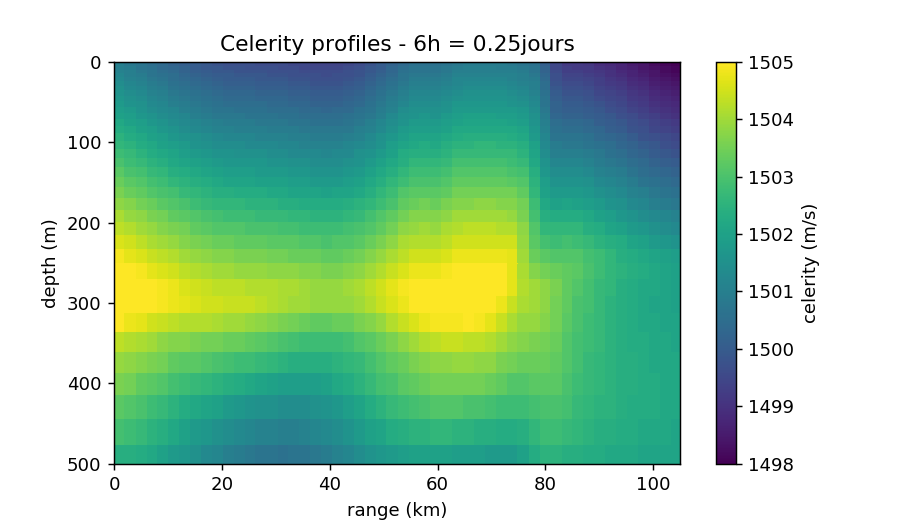

In [33]:
### Animation
fig, ax = plt.subplots(figsize=(7, 4))
ax.set(xlim=(0., 105.), ylim=(0., 500.))
   
cax = ax.pcolormesh(r_prof, d_prof, MAT_prof[:, :, 0], vmin=1498., vmax=1505.)
cbar = fig.colorbar(cax)
plt.gca().invert_yaxis()
plt.xlabel('range (km)')
plt.ylabel('depth (m)')
cbar.set_label("celerity (m/s)")
    
def animate(i):
    cax.set_array((MAT_prof[:-1,:-1,i]).flatten())
    plt.title('Celerity profiles - %dh = %.2fjours' %(time[i], time[i]/24.))

anim = FuncAnimation(fig, animate, interval=5.e2, frames=MAT_prof.shape[2])
plt.draw()
plt.show()

In [32]:
# export the animation
#anim.save('celerity_profiles.gif', writer='imagemagick')